# Importación de librerías

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

from src.template_matching_functions import *
from src.utility_functions import *

# Detección en cada imagen
Obtener una detección del logo en cada imagen sin falsos positivos

----

In [2]:
template_path = 'template/pattern.png'
images_directory = 'images'

A continuación, se leen todas las imágenes mediante la función [read_images_from_directory](src/utility_functions.py) y se obtiene una detección de cada imagen mediante la función [detect_single_logo_in_image](src/template_matching_functions.py). Esta función recibe una imagen, un template y muestra la detección del template en la imagen con un nivel de confianza determinado.

Median value: 74.0, lower: 10, upper: 250
Template height ratio: 0.29264214046822745
Template width ratio: 0.5006257822277848
Best scale: 0.2
Best matching score: 0.2931707799434662


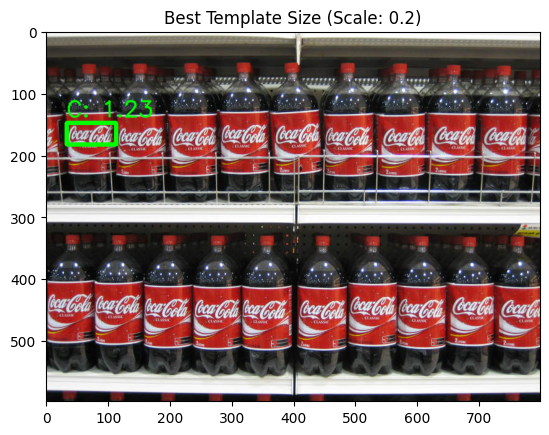

Median value: 83.0, lower: 300, upper: 450
Template height ratio: 0.40792540792540793
Template width ratio: 0.5594405594405595
Best scale: 0.5
Best matching score: 0.2295190691947937


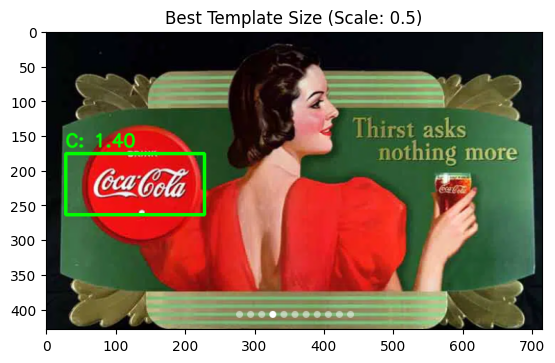

Median value: 94.0, lower: 300, upper: 450
Template height ratio: 0.35
Template width ratio: 1.932367149758454
Best scale: 0.5
Best matching score: 0.16821308434009552


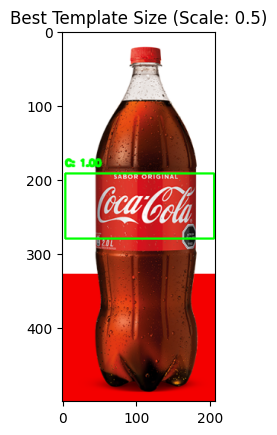

High contrast image
Median value: 224.0, lower: 100, upper: 540
Template height ratio: 0.35496957403651114
Template width ratio: 0.5594405594405595
Best scale: 1.3421052631578947
Best matching score: 0.14974960684776306


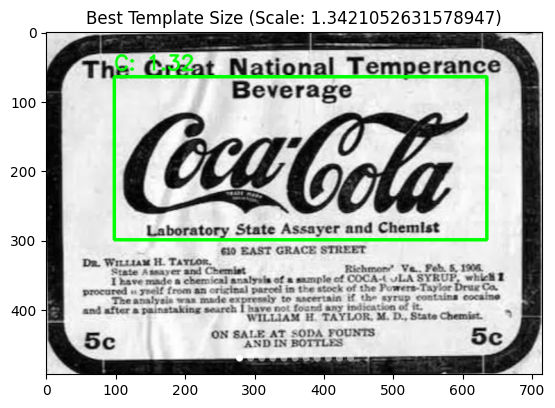

Median value: 41.0, lower: 10, upper: 250
Template height ratio: 0.3888888888888889
Template width ratio: 0.5822416302765647
Best scale: 0.763157894736842
Best matching score: 0.21383625268936157


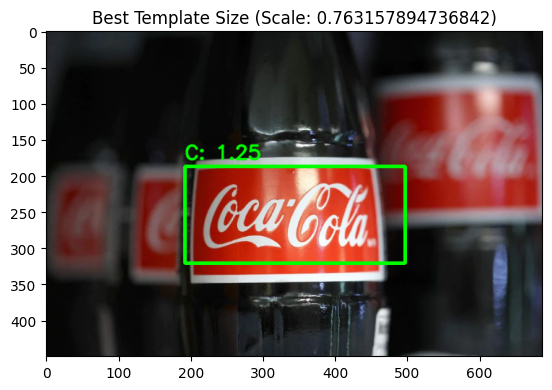

Median value: 80.0, lower: 300, upper: 450
Template height ratio: 0.4820936639118457
Template width ratio: 1.7167381974248928
Best scale: 0.5526315789473684
Best matching score: 0.18192866444587708


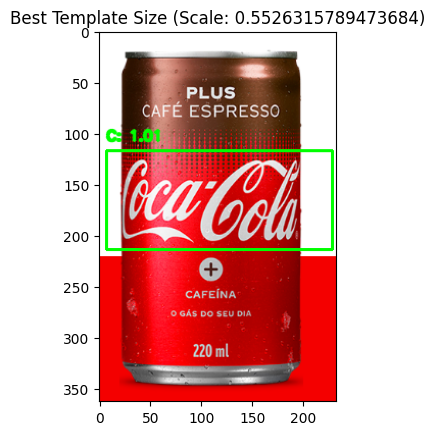

Median value: 92.0, lower: 300, upper: 450
Template height ratio: 0.1259899208063355
Template width ratio: 0.28797696184305255
Best scale: 3.1578947368421053
Best matching score: 0.08287764340639114


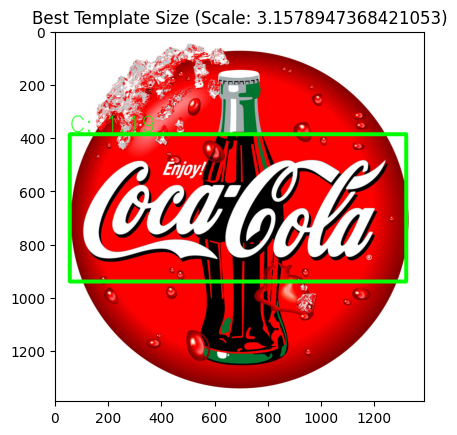

In [3]:
# Read images from the directory
images = read_images_from_directory(images_directory)

for img_path in images:
    # Detect the logo in the current image
    detect_single_logo_in_image(img_path, template_path)

El nivel de confianza se calculó mediante la función [calculate_confidence_level](src/utility_functions.py). Esta función recibe una lista de scores, junto con el mejor score encontrado (`best_max_val`). El nivel de confianza se calcula como la relación entre el mejor score y el percentil 90 de los scores, proporcionando una medida de cuán superior es el mejor score en comparación con la mayoría de los scores obtenidos.

Un nivel de confianza cercano o igual a 1 indica que la detección es correcta, ya que el mejor score es comparable al percentil 90 de los scores. Un nivel de confianza mayor a 1 indica que la detección es muy buena, ya que el mejor score es superior al percentil 90, sugiriendo que la coincidencia es significativamente mejor que la mayoría. Un nivel de confianza menor a 1 indica que la detección es mala, ya que el mejor score es inferior al percentil 90, sugiriendo una coincidencia débil en comparación con la mayoría.

# Múltiples detecciones en una imagen

Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1

----

En la siguiente celda, se lleva a cabo el siguiente procedimiento:

- Se carga la imagen principal y el template desde sus respectivos archivos, y luego ambas imágenes se convierten a escala de grises para simplificar el procesamiento.
- Se aplica un filtro gaussiano a la imagen principal para reducir el ruido y mejorar la detección de bordes.
- el template se redimensiona de acuerdo con una proporción definida con respecto al tamaño de la imagen principal, calculando las nuevas dimensiones basadas en el tamaño deseado.
- Se aplica el detector de bordes de Canny tanto a la imagen principal como al template redimensionado para resaltar los contornos.
- Se realiza la coincidencia del template sobre la imagen principal utilizando la técnica de `cv.matchTemplate` con el método `cv.TM_CCOEFF_NORMED`.
- Se establece un umbral para determinar las ubicaciones en la imagen principal donde la coincidencia del template supera dicho umbral.
- Se aplican técnicas de *Non Maximum Suppression* (supresión de no-máximos) para eliminar coincidencias redundantes y mantener solo las más significativas.
- Se dibujan rectángulos alrededor de las coincidencias detectadas en la imagen original y se muestran los resultados.


19 objects detected with confidence levels [np.float32(1.2279857), np.float32(1.1467801), np.float32(1.1422123), np.float32(1.1399288), np.float32(1.1322327), np.float32(1.1285353), np.float32(1.0978482), np.float32(1.0693481), np.float32(1.0435449), np.float32(1.0378901), np.float32(1.0002208), np.float32(0.99210656), np.float32(0.9902978), np.float32(0.9829887), np.float32(0.97111607), np.float32(0.9526841), np.float32(0.9285077), np.float32(0.8753808), np.float32(0.8478854)]


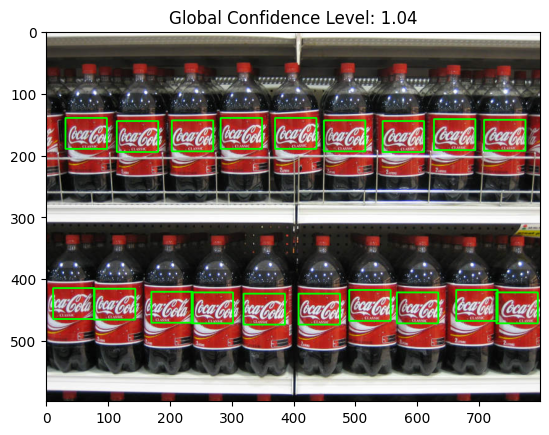

In [4]:
# Load the image and convert to grayscale
img_rgb = cv.imread('images/coca_multi.png')
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

# Load the template and get its dimensions
template = cv.imread('template/pattern.png', 0)

# Apply Gaussian blur to the image
img_gray_blurred = cv.GaussianBlur(img_gray, (5, 5), 0)

# Get dimensions of the image and template
img_height, img_width = img_gray_blurred.shape

# Define the desired size ratio for the template
size_ratio = 0.085

# Calculate new dimensions for the template based on the size ratio
new_template_width = int(img_width * size_ratio)
new_template_height = int(img_height * size_ratio)

# Resize the template
template = cv.resize(template, (new_template_width, new_template_height))

# Get the dimensions of the resized template
template_width, template_height = template.shape[::-1]

# Apply Canny edge detection to the image and template
template_edges = cv.Canny(template, 50, 300, L2gradient=True)
img_gray_edges = cv.Canny(img_gray_blurred, 10, 250, apertureSize=3, L2gradient=True)

# Perform template matching
res = cv.matchTemplate(img_gray_edges, template_edges, cv.TM_CCOEFF_NORMED)

# Set the threshold for the template matching result
threshold = 0.16

# Find the locations where the template matches the image
loc = np.where(res >= threshold)

# Prepare lists of bounding boxes and scores
boxes = []
scores = []

for pt in zip(*loc[::-1]):
    boxes.append([pt[0], pt[1], template_width, template_height])
    scores.append(res[pt[1], pt[0]])

boxes = np.array(boxes)
scores = np.array(scores)

# Apply non-maximum suppression
iou_threshold = 0.3
keep, keep_scores = non_max_suppression(boxes, scores, iou_threshold)

# Compute the confidence level for each bounding box
confidence_levels = [calculate_confidence_level(scores, score) for score in keep_scores]

# Get the global confidence level
global_confidence_level = np.mean(confidence_levels)

print(f'{len(confidence_levels)} objects detected with confidence levels {confidence_levels}')


# Draw rectangles around the kept bounding boxes
for i in keep:
    box = boxes[i]
    cv.rectangle(img_rgb, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (0, 255, 0), 2)

# Display the result
plt.imshow(cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB))
plt.title(f'Global Confidence Level: {global_confidence_level:.2f}')
plt.show()

En la imagen superior se puede ver que se logran detectar todos los logos presentes en la imagen, utilizando el template. También se puede observar que se calcula el nivel de confianza global de 1.04, lo que indica en general una buena detección de los logos en la imagen. Si bien el algoritmo logra detectar todos los logos presentes en la imagen, puede que este sea muy dependiente del tamaño del template y de la imagen principal. Por lo tanto, se planteará un algoritmo que pueda ser más robusto a diferentes tamaños de template y de la imagen principal.

----

A continuación, se obtiene una detección de múltiples logos en la imagen coca_multi.png mediante la función [detect_multiple_logo_in_image](src/template_matching_functions.py). Esta función recibe una imagen, un template y muestra la detección de múltiples logos en la imagen con un nivel de confianza global calculado como el promedio de los niveles de confianza de cada una de las detecciones que pasaron el umbral de confianza.

Para abordar el problema del planteamiento anterior y buscar un algoritmo más compatible con otras imagenes. Esta función busca la escala de template que tenga el score mayor al hacer match con la imagen. Luego se realiza el reescalado y se procede de manera similar al algoritmo anterior.

Median value: 74.0, lower: 10, upper: 250
Template height ratio: 0.29264214046822745
Template width ratio: 0.5006257822277848
Best scale: 0.2


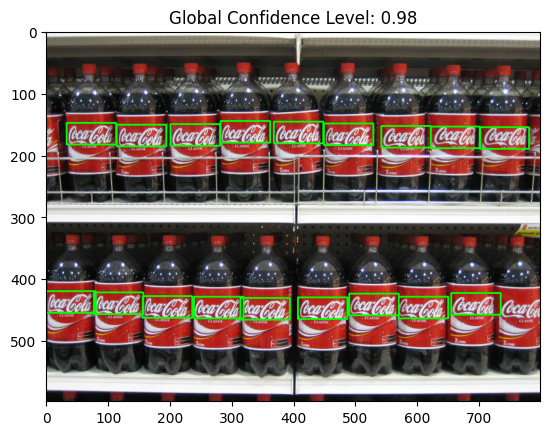

In [5]:
image_path = 'images/coca_multi.png'
template_path = 'template/pattern.png'

detect_multiple_logo_in_image(image_path, template_path)

Se puede ver que el algoritmo detecta correctamente los logos en la imagen, en este caso con un nivel de confianza global de 0.98. Sin embargo, se logra un algortimo mucho más robusto que podrá ser utilizado en el siguiente item.

# Generalización del algoritmo de detección

Generalizar el algoritmo del item 2 para todas las imágenes.

----

Se vuelve a utilizar [detect_multiple_logo_in_image](src/template_matching_functions.py) para realizar la detección en todas las imágenes. 

Median value: 74.0, lower: 10, upper: 250
Template height ratio: 0.29264214046822745
Template width ratio: 0.5006257822277848
Best scale: 0.2


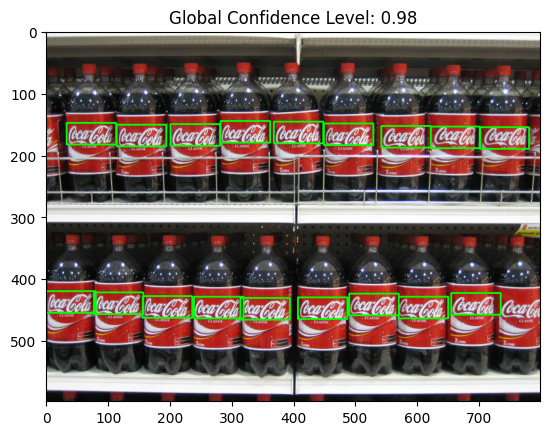

Median value: 83.0, lower: 300, upper: 450
Template height ratio: 0.40792540792540793
Template width ratio: 0.5594405594405595
Best scale: 0.5


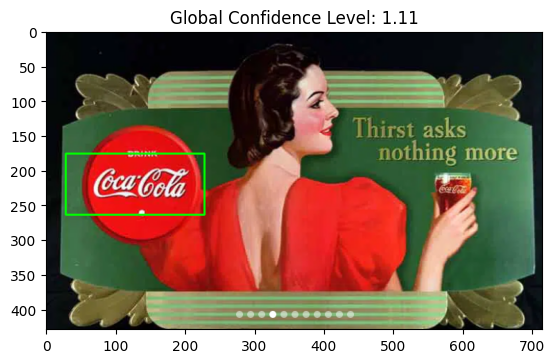

Median value: 94.0, lower: 300, upper: 450
Template height ratio: 0.35
Template width ratio: 1.932367149758454
Best scale: 0.5


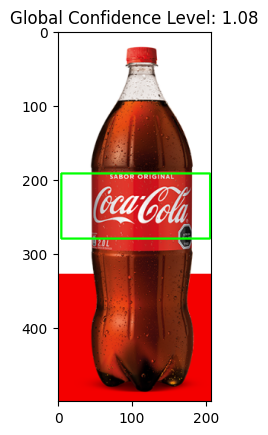

High contrast image
Median value: 224.0, lower: 100, upper: 540
Template height ratio: 0.35496957403651114
Template width ratio: 0.5594405594405595
Best scale: 1.3421052631578947


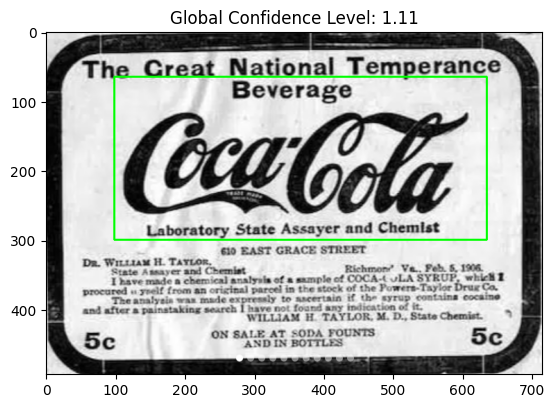

Median value: 41.0, lower: 10, upper: 250
Template height ratio: 0.3888888888888889
Template width ratio: 0.5822416302765647
Best scale: 0.763157894736842


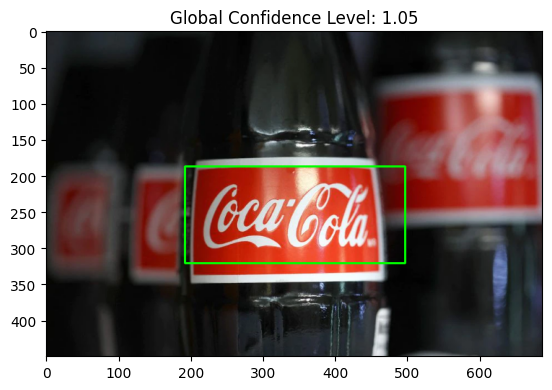

Median value: 80.0, lower: 300, upper: 450
Template height ratio: 0.4820936639118457
Template width ratio: 1.7167381974248928
Best scale: 0.5526315789473684


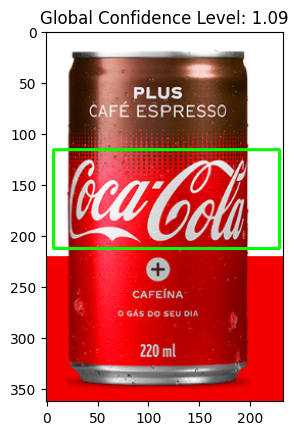

Median value: 92.0, lower: 300, upper: 450
Template height ratio: 0.1259899208063355
Template width ratio: 0.28797696184305255
Best scale: 3.1578947368421053


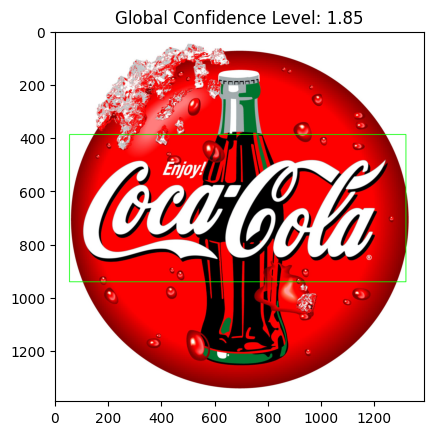

In [6]:
template_path = 'template/pattern.png'
images_directory = 'images'

# Read images from the directory
images = read_images_from_directory(images_directory)

for img_path in images:
    # Detect the logo in the current image
    detect_multiple_logo_in_image(img_path, template_path)

Como se puede ver en las imágenes, el algoritmo detecta correctamente los logos en las imágenes, con un nivel de confianza mayor a 1 para los logos individuales y un nivel de confianza global cercano a 1 para los logos múltiples. Dado que la misma función se utiliza para detectar los logos en todas las imágenes, se considera que el algoritmo es generalizable.